## Data analysis, preparation and visualization
Data preparation for the ECG challenge on Kaggle.

Directory 0 (1006867983): 10 files
Directory 1 (1006427285): 10 files
Directory 2 (1012423188): 10 files


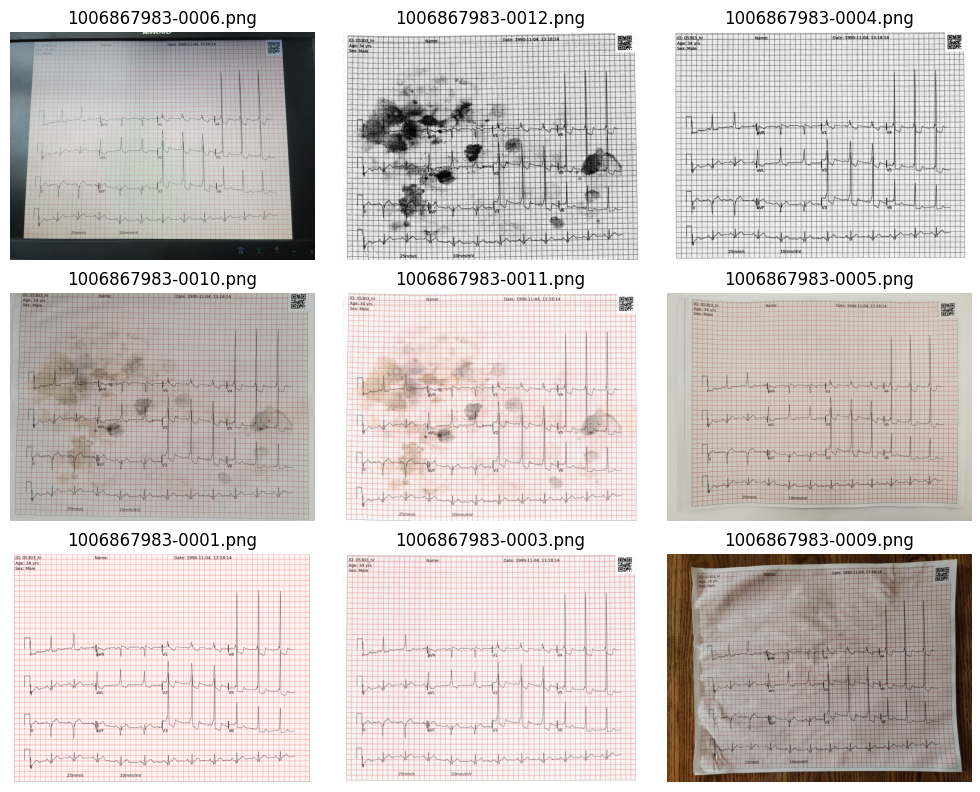

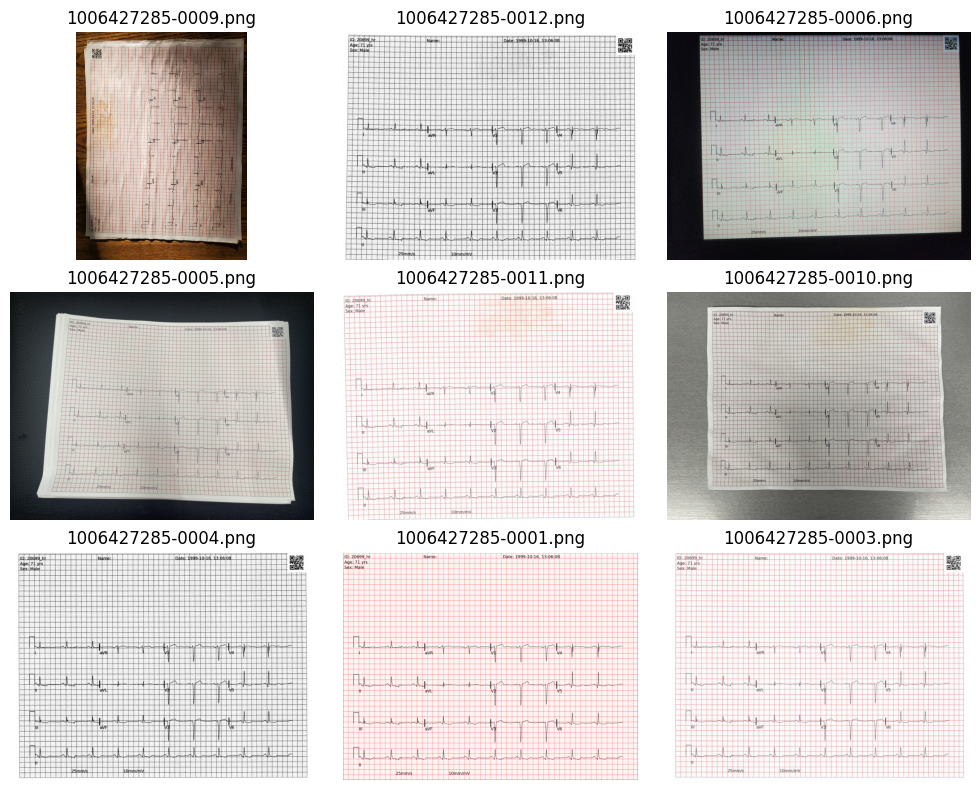

In [ ]:
import matplotlib.pyplot as plt
import numpy
import matplotlib.image as mpimg
import os

image_path = 'ECG_dataset/physionet-ecg-image-digitization'

def explain_directories(Directory):
    files_per_dir = []
    file_count = 0
    for root, subdirs, files in os.walk(Directory):
        if not files:
            continue
        files_per_dir.append((root, files))
        file_count += len(files)
    return file_count, files_per_dir

num_files, dirs_files = explain_directories(image_path)

for i, (root, files) in enumerate(dirs_files):
    print(f"Directory {i} ({os.path.basename(root)}): {len(files)} files")

for root, folder_files in dirs_files:
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
    axes = axes.flat

    image_count = 0
    for file in folder_files:
        if not file.lower().endswith(('.png')):
            continue
        
        img_path = os.path.join(root, file)
        img_plot = mpimg.imread(img_path)
        axes[image_count].imshow(img_plot)
        axes[image_count].set_title(file)
        axes[image_count].axis('off')
        image_count += 1

        if image_count >= 9:
            break

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np

signals = pd.read_csv('/kaggle/input/physionet-ecg-image-digitization/train.csv')

signals["fs"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Sampling frequency (Hz)")
plt.ylabel("Number of records")
plt.title("Distribution of fs")
plt.show()

In [ ]:
from scipy.signal import butter, filtfilt

for file in files_name:
    if file.endswith('.csv'):
            lead_test = pd.read_csv(os.path.join(test_image_path,file))
            id_ = int(file.replace(".csv", ""))

frequency = signals.loc[signals["id"] == id_, "fs"].iloc[0]
time = np.arange(len(lead_test)) / frequency

fig,axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
axes = axes.flat

def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=500, order=2):
    nyquist = 0.5 * fs
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    return filtfilt(b, a, signal)


for ax,lead in zip(axes,lead_test.columns):
    ax.plot(time, lead_test[lead].values)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude ")
    ax.set_title(f'lead name:  {lead}')
plt.tight_layout()
plt.show()

In [ ]:
img = cv2.imread('/kaggle/input/physionet-ecg-image-digitization/train/1006427285/1006427285-0001.png')
h1 = int(img.shape[0] * 1 / 3)
crop_img = img[h1:, :, :].copy()      
H, W = crop_img.shape[:2]

cluster_means = sorted(means)
vertical_cuts = [0] + cluster_means + [W]
horizontal_cuts = [0, 300, 600, 875]  

lead_crops_color = []
for i in range(3):      # rows
    for j in range(4):  # cols
        y1, y2 = horizontal_cuts[i], horizontal_cuts[i+1]
        x1, x2 = vertical_cuts[j], vertical_cuts[j+1]
        lead_crops_color.append(crop_img[y1:y2, x1:x2])


def make_clean_trace(tile_bgr):
    hsv = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2HSV)

    lower_red1 = np.array([0,  50,  50])
    upper_red1 = np.array([15, 255, 255])
    lower_red2 = np.array([170, 50,  50])
    upper_red2 = np.array([180, 255, 255])

    mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
    grid_mask = cv2.bitwise_or(mask_red1, mask_red2)

    no_grid = tile_bgr.copy()
    no_grid[grid_mask > 0] = (255, 255, 255)
    gray = cv2.cvtColor(no_grid, cv2.COLOR_BGR2GRAY)

    _, trace_1 = cv2.threshold(gray, 0, 255,
                             cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    trace = 255 - trace_1
    kernel = np.ones((1, 1), np.uint8)
    trace = cv2.morphologyEx(trace, cv2.MORPH_OPEN, kernel, iterations=1)

    return trace, no_grid

lead_traces = []
lead_nogrid = []

for tile in lead_crops_color:
    trace, ng = make_clean_trace(tile)
    lead_traces.append(trace)
    lead_nogrid.append(ng)

leads = ['I', 'aVR','V1','V4','II','aVL','V2','V5','III','aVF','V3','V6']

fig, axes = plt.subplots(3, 4, figsize=(10, 7))
for idx, ax in enumerate(axes.flat):
    ax.imshow(lead_traces[idx], cmap='gray')    
    ax.set_title(f"Lead {leads[idx]}")
    ax.axis("off")
plt.tight_layout()
plt.show()